# Introduction: Hyperparameter Optimization

In this notebook we will explore several options for hyperparameter optimization of a machine learning algorithm. We will start with some of the basic methods such as random search, and then proceed to more sophisticated methods using Guassian Processes.

In [1]:
import pandas as pd
import numpy as np

import lightgbm as lgb

from sklearn.model_selection import RandomizedSearchCV, KFold

In [2]:
import random

In [3]:
model = lgb.LGBMClassifier(objective = 'binary', n_jobs = -1, boosting_type='goss', colsample_bytree=0.8)

In [8]:
data['ORIGIN'].value_counts()

train    5822
test     4000
Name: ORIGIN, dtype: int64

In [9]:
data = pd.read_csv('data/caravan-insurance-challenge.csv')
train = data[data['ORIGIN'] == 'train']
test = data[data['ORIGIN'] == 'test']

,ORIGIN,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,CARAVAN
0,train,33,1,3,2,8,0,5,1,3,...,0,0,0,1,0,0,0,0,0,0
1,train,37,1,2,2,8,1,4,1,4,...,0,0,0,1,0,0,0,0,0,0
2,train,37,1,2,2,8,0,4,2,4,...,0,0,0,1,0,0,0,0,0,0
3,train,9,1,3,3,3,2,3,2,4,...,0,0,0,1,0,0,0,0,0,0
4,train,40,1,4,2,10,1,4,1,4,...,0,0,0,1,0,0,0,0,0,0


# Random Search by Hand

The first method we can implement is simply random search. Each iteration, choose a random set of model hyperparameters from a search space. Empirically, random search is very effective, returning nearly as good results as grid search with a significant reduction in time spent searching. 

Random search can be implement in the Scikit-Learn library with the LightGBM Sklearn API. However, this does not support training with early stopping, which is the most effective method for determining the best number of iterations to use. Therefore, we will implement random search ourselves with a defined parameter grid, and using Early Stopping.

In [10]:
train_labels = np.array(train['CARAVAN'].astype(np.int32)).reshape((-1,))
test_labels = np.array(test['CARAVAN'].astype(np.int32)).reshape((-1,))

train = train.drop(columns = ['ORIGIN', 'CARAVAN'])
test = test.drop(columns = ['ORIGIN', 'CARAVAN'])

In [11]:
print('Train shape: ', train.shape)

Train shape:  (5822, 85)


In [15]:
features = np.array(train)
labels = train_labels

In [12]:
lgb.LGBMClassifier()

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)

In [13]:
param_grid = {
    'class_weight': [None, 'balanced'],
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(30, 151)),
    'learning_rate': list(np.logspace(np.log(0.01), np.log(0.2), base = np.exp(1), num = 100)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10))
}

subsample_dist = list(np.linspace(0.5, 1, 100))

In [14]:
evals = 5

# Dataframe to hold cv results
results = pd.DataFrame(columns = ['params', 'train_scores', 'train', 'valid_scores', 'valid', 'estimators'],
                       index = list(range(evals)))

In [16]:
# Iterate through the specified number of evaluations
for i in range(evals):
    
    k_fold = KFold(n_splits = 5)
    
    # Randomly sample parameters for gbm
    params = {key: random.sample(value, 1)[0] for key, value in param_grid.items()}
    
    
    if params['boosting_type'] == 'goss':
        # Cannot subsample with goss
        params['subsample'] = 1.0
    else:
        # Subsample supported for gdbt and dart
        params['subsample'] = random.sample(subsample_dist, 1)[0]
        
        
    # Create the model with the parameters
    model = lgb.LGBMClassifier(class_weight = params['class_weight'], boosting_type = params['boosting_type'], 
                               num_leaves = params['num_leaves'], learning_rate = params['learning_rate'], 
                               subsample_for_bin = params['subsample_for_bin'], min_child_samples = params['min_child_samples'], 
                               reg_alpha = params['reg_alpha'], reg_lambda = params['reg_lambda'], 
                               colsample_by_tree = params['colsample_bytree'], subsample = params['subsample'], 
                               n_estimators = 10000, n_jobs = -1, objective = 'binary')
    
    # Empty lists for records
    valid_scores = []
    train_scores = []
    number_estimators = []
    
    # Split the data
    for (train_indices, valid_indices) in k_fold.split(features):
        
        # Training data and validation set
        train_features, train_labels = features[train_indices], labels[train_indices]
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Fit the model using early stopping
        model.fit(train_features, train_labels, eval_set = [(train_features, train_labels), (valid_features, valid_labels)],
                  eval_metric = 'auc', eval_names = ['train', 'valid'], early_stopping_rounds = 200, verbose = 200)
        
        
        valid_scores.append(model.best_score_['valid']['auc'])
        train_scores.append(model.best_score_['train']['auc'])
        number_estimators.append(model.best_iteration_)
        
    # Average the scores
    valid = np.mean(valid_scores)
    train = np.mean(train_scores)
    estimators = np.mean(number_estimators)
    
    # Add results to next row in dataframe
    results.loc[i, :] = [params, train_scores, train, valid_scores, valid, estimators]

Training until validation scores don't improve for 200 rounds.
[200]	train's auc: 0.775115	valid's auc: 0.764742
Early stopping, best iteration is:
[50]	train's auc: 0.76741	valid's auc: 0.767567
Training until validation scores don't improve for 200 rounds.
[200]	train's auc: 0.780657	valid's auc: 0.742874
[400]	train's auc: 0.800372	valid's auc: 0.754224
[600]	train's auc: 0.811003	valid's auc: 0.755748
Early stopping, best iteration is:
[586]	train's auc: 0.810291	valid's auc: 0.756867
Training until validation scores don't improve for 200 rounds.
[200]	train's auc: 0.778437	valid's auc: 0.74782
[400]	train's auc: 0.799946	valid's auc: 0.757051
Early stopping, best iteration is:
[394]	train's auc: 0.799334	valid's auc: 0.757856
Training until validation scores don't improve for 200 rounds.
[200]	train's auc: 0.784527	valid's auc: 0.736457
[400]	train's auc: 0.804592	valid's auc: 0.742194
[600]	train's auc: 0.816903	valid's auc: 0.743128
[800]	train's auc: 0.824552	valid's auc: 0.741

In [17]:
results = results.sort_values('valid', ascending = False)

In [18]:
results.iloc[0, 0]

{'boosting_type': 'goss',
 'class_weight': 'balanced',
 'colsample_bytree': 0.8666666666666667,
 'learning_rate': 0.11254789331428304,
 'min_child_samples': 400,
 'num_leaves': 48,
 'reg_alpha': 0.42857142857142855,
 'reg_lambda': 0.5714285714285714,
 'subsample': 1.0,
 'subsample_for_bin': 60000}

## Bayesian Hyperparameter Optimization using Hyperopt

In [19]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from hyperopt.pyll.stochastic import sample

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

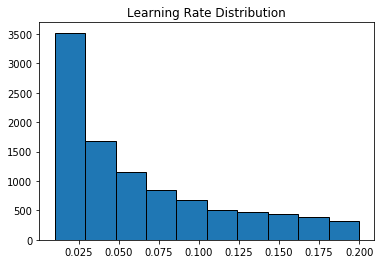

In [21]:
learning_rate = {'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2))}
learning_rate_dist = []

for _ in range(10000):
    learning_rate_dist.append(sample(learning_rate)['learning_rate'])
    
plt.hist(learning_rate_dist, bins = 10, edgecolor = 'k');
plt.title('Learning Rate Distribution');

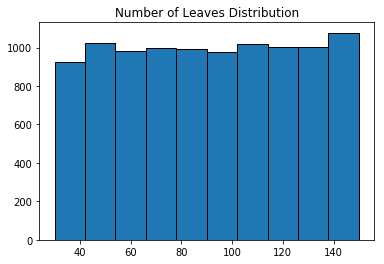

In [22]:
num_leaves = {'num_leaves': hp.quniform('num_leaves', 30, 150, 1)}
num_leaves_dist = []

for _ in range(10000):
    num_leaves_dist.append(sample(num_leaves)['num_leaves'])
    
plt.hist(num_leaves_dist, bins = 10, edgecolor = 'k');
plt.title('Number of Leaves Distribution');

In [23]:
def objective(params):
    k_fold = KFold(n_splits = 5)
    
    # Retrieve the subsample if present otherwise set to 1.0
    subsample = params['boosting_type'].get('subsample', 1.0)
    
    # Extract the boosting type
    params['boosting_type'] = params['boosting_type']['boosting_type']
    params['subsample'] = subsample
    
    # Make sure parameters that need to be integers are integers
    for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_child_samples']:
        params[parameter_name] = int(params[parameter_name])
    
    model = lgb.LGBMClassifier(n_estimators = 10000, objective = 'binary', n_jobs = -1, **params)
    
    valid_scores = []
    train_scores = []
    number_estimators = []
    
    for (train_indices, valid_indices) in k_fold.split(features):
        
        # Training data and validation set
        train_features, train_labels = features[train_indices], labels[train_indices]
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Fit the model using early stopping
        model.fit(train_features, train_labels, eval_set = [(train_features, train_labels), (valid_features, valid_labels)],
                  eval_metric = 'auc', eval_names = ['train', 'valid'], early_stopping_rounds = 200, verbose = 200)
    
        valid_scores.append(model.best_score_['valid']['auc'])
        train_scores.append(model.best_score_['train']['auc'])
        number_estimators.append(model.best_iteration_)
        
    # fmin needs a loss to minimize
    valid = -1 * np.mean(valid_scores)
    train = -1 * np.mean(train_scores)
    
    # average number of estimators
    estimators = np.mean(number_estimators)
    
    # Dictionary with information for evaluation
    return {'loss': valid, 'train': train, 'estimators': estimators, 'status': STATUS_OK, 'params': params}

In [24]:
# Define the search space
space = {
    'class_weight': hp.choice('class_weight', [None, 'balanced']),
    'boosting_type': hp.choice('boosting_type', [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}, 
                                                 {'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.5, 1)},
                                                 {'boosting_type': 'goss'}]),
    'num_leaves': hp.quniform('num_leaves', 30, 150, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0)
}

In [25]:
boosting_type = {'boosting_type': hp.choice('boosting_type', [{'boosting_type': 'gbdt', 'subsample': hp.uniform('subsample', 0.5, 1)}, 
                                                 {'boosting_type': 'dart', 'subsample': hp.uniform('subsample', 0.5, 1)},
                                                 {'boosting_type': 'goss'}])}

In [26]:
sample(boosting_type)

{'boosting_type': {'boosting_type': 'dart', 'subsample': 0.5448263132709272}}

In [27]:
sample(boosting_type)

{'boosting_type': {'boosting_type': 'goss'}}

In [28]:
learning_rate = {'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.5))}

In [29]:
sample(learning_rate)

{'learning_rate': 0.10246628540254063}

In [30]:
sample(learning_rate)

{'learning_rate': 0.469495016519224}

In [31]:
x = sample(space)

### Example of Sampling from the space

After finding the boosting type (which is in a nested dictionary), we assign the boosting type to make it a top level value. We use the dictionary get method to find the 'subsample' if it is in the dictionary (indicating the boosting type is 'gbdt' or 'dart') or set it to 1.0 otherwise (if boosting type is 'goss'). The goss boosting type cannot use bagging. 

This entire step is necessary because of the conditional logic used for the boosting type and subsample ratio.

In addition, we can see the other variables in the dictionary. These will change every time we sample the space.

In [32]:
x = sample(space)
subsample = x['boosting_type'].get('subsample', 1.0)
x['boosting_type'] = x['boosting_type']['boosting_type']
x['subsample'] = subsample
x

{'boosting_type': 'goss',
 'class_weight': 'balanced',
 'colsample_bytree': 0.9773709356748352,
 'learning_rate': 0.1407872278538297,
 'min_child_samples': 105.0,
 'num_leaves': 79.0,
 'reg_alpha': 0.8289180262156219,
 'reg_lambda': 0.9396350305932608,
 'subsample': 1.0,
 'subsample_for_bin': 200000.0}

In [33]:
x = sample(space)
subsample = x['boosting_type'].get('subsample', 1.0)
x['boosting_type'] = x['boosting_type']['boosting_type']
x['subsample'] = subsample
x

{'boosting_type': 'goss',
 'class_weight': None,
 'colsample_bytree': 0.9758127829844948,
 'learning_rate': 0.12465302831811688,
 'min_child_samples': 260.0,
 'num_leaves': 46.0,
 'reg_alpha': 0.43822106428507823,
 'reg_lambda': 0.9935940347050338,
 'subsample': 1.0,
 'subsample_for_bin': 140000.0}

## Optimization

In [34]:
trials = Trials()

best = fmin(fn = objective, space = space, algo = tpe.suggest, 
            max_evals = 5, trials = trials, verbose = 1)

Training until validation scores don't improve for 200 rounds.
[200]	train's auc: 0.986375	valid's auc: 0.745473
Early stopping, best iteration is:
[44]	train's auc: 0.958769	valid's auc: 0.759309
Training until validation scores don't improve for 200 rounds.
[200]	train's auc: 0.986927	valid's auc: 0.727371
Early stopping, best iteration is:
[82]	train's auc: 0.971015	valid's auc: 0.734203
Training until validation scores don't improve for 200 rounds.
[200]	train's auc: 0.986819	valid's auc: 0.718099
Early stopping, best iteration is:
[25]	train's auc: 0.945166	valid's auc: 0.760057
Training until validation scores don't improve for 200 rounds.
[200]	train's auc: 0.987977	valid's auc: 0.675256
Early stopping, best iteration is:
[2]	train's auc: 0.889926	valid's auc: 0.7189
Training until validation scores don't improve for 200 rounds.
[200]	train's auc: 0.987507	valid's auc: 0.768098
Early stopping, best iteration is:
[27]	train's auc: 0.94688	valid's auc: 0.793174
Training until vali

In [35]:
trials.results

[{'estimators': 36.0,
  'loss': -0.7531284893259564,
  'params': {'boosting_type': 'goss',
   'class_weight': 'balanced',
   'colsample_bytree': 0.776451135695361,
   'learning_rate': 0.0906304378048697,
   'min_child_samples': 50,
   'num_leaves': 140,
   'reg_alpha': 0.12158717564944999,
   'reg_lambda': 0.4931382166652518,
   'subsample': 1.0,
   'subsample_for_bin': 180000},
  'status': 'ok',
  'train': -0.9423513267898096},
 {'estimators': 275.6,
  'loss': -0.7705744625325598,
  'params': {'boosting_type': 'dart',
   'class_weight': None,
   'colsample_bytree': 0.9606907171119059,
   'learning_rate': 0.07241862479138476,
   'min_child_samples': 330,
   'num_leaves': 110,
   'reg_alpha': 0.6950854939937159,
   'reg_lambda': 0.7675299590592802,
   'subsample': 0.6845930617820666,
   'subsample_for_bin': 280000},
  'status': 'ok',
  'train': -0.825258553577582},
 {'estimators': 295.2,
  'loss': -0.7646214841709227,
  'params': {'boosting_type': 'goss',
   'class_weight': None,
   'co

In [36]:
trials_results = sorted(trials.results, key = lambda x: x['loss'])

In [37]:
trials_results[:2]

[{'estimators': 275.6,
  'loss': -0.7705744625325598,
  'params': {'boosting_type': 'dart',
   'class_weight': None,
   'colsample_bytree': 0.9606907171119059,
   'learning_rate': 0.07241862479138476,
   'min_child_samples': 330,
   'num_leaves': 110,
   'reg_alpha': 0.6950854939937159,
   'reg_lambda': 0.7675299590592802,
   'subsample': 0.6845930617820666,
   'subsample_for_bin': 280000},
  'status': 'ok',
  'train': -0.825258553577582},
 {'estimators': 66.4,
  'loss': -0.7678895886814731,
  'params': {'boosting_type': 'dart',
   'class_weight': None,
   'colsample_bytree': 0.6280078172616956,
   'learning_rate': 0.09972694522999238,
   'min_child_samples': 105,
   'num_leaves': 81,
   'reg_alpha': 0.3814007444662817,
   'reg_lambda': 0.03618407438622695,
   'subsample': 0.5365751881812449,
   'subsample_for_bin': 240000},
  'status': 'ok',
  'train': -0.8446608334913197}]

In [38]:
import json

with open('trials.json', 'w') as f:
    f.write(json.dumps(trials_results))